### DATA CLEANING

In [212]:
#importing Libraries

import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
%matplotlib inline

In [172]:

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, make_scorer,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

C:\Users\Palak08\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [22]:
#Reading the data directly
df = pd.read_excel("Listings Data.xlsx")

In [131]:
df.head()

,id,host_id,zipcode,property_type,room_type,accommodates,bedrooms,beds,bed_type,price,number_of_reviews,review_scores_rating,calculated_host_listings_count,availability_30,minimum_nights,bathrooms,price_log
0,14831696,5476119,1054,Apartment,Entire home/apt,2.193809,0.664082,2.904320,Real Bed,145,-0.396740,95.0,-0.215734,2.555512,0.016277,-0.344516,4.976734
1,3951251,3526186,1057GV,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,88,-0.022605,93.0,-0.215734,-0.508813,-0.122313,-0.344516,4.477337
2,16590973,12749039,1054XH,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,130,-0.396740,100.0,-0.215734,1.023349,-0.122313,-0.344516,4.867534
3,9283701,46755996,1057 XD,Apartment,Entire home/apt,0.770248,0.664082,0.792239,Real Bed,110,-0.454299,100.0,-0.104231,-0.508813,0.154868,-0.344516,4.700480
4,6458721,15317293,1053 NE,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,115,-0.224062,96.0,-0.215734,0.147828,0.016277,-0.344516,4.744932


In [213]:
cols = [
    'id',
    'host_id',
    'zipcode',
    'property_type',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'bed_type',
    'price',
    'number_of_reviews',
    'review_scores_rating',
    'host_listing_count',
    'availability_30',
    'minimum_nights',
    'bathrooms'
]

In [16]:
# Dropping columns with more than 80% missing values
df = df.dropna(axis=1, thresh=int(0.80*len(df)))

In [17]:
#df.drop(['listing_url','picture_url','host_url','host_thumbnail_url','host_picture_url','host_has_profile_pic','host_identity_verified','country_code','is_location_exact','experiences_offered','host_name','last_scraped'], axis=1, inplace=True)
#'host_url','host_thumbnail_url','host_picture_url','host_has_profile_pic','host_identity_verified','country_code','is_location_exact'

In [24]:
#Selecting only relevant columns
df=df[cols]

In [214]:
df.shape

(15181, 17)

In [215]:
# determine the number of missing entries in each column
for col in df.columns:
    print (col + ', Number of Missing Values:', len(df[col][df[col].isnull()]))

id, Number of Missing Values: 0
host_id, Number of Missing Values: 0
zipcode, Number of Missing Values: 653
property_type, Number of Missing Values: 0
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bedrooms, Number of Missing Values: 12
beds, Number of Missing Values: 17
bed_type, Number of Missing Values: 0
price, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
review_scores_rating, Number of Missing Values: 2317
calculated_host_listings_count, Number of Missing Values: 0
availability_30, Number of Missing Values: 0
minimum_nights, Number of Missing Values: 0
bathrooms, Number of Missing Values: 18
price_log, Number of Missing Values: 0


In [216]:
# remove NaN values from dataframe
original = len(df)
data = df.dropna(how='any', subset=['zipcode', 'property_type', 'bedrooms', 'beds', 'bathrooms'])
print('Number of NaN values removed:', original - len(data))

# drop any inconsistent values
print('Number of Accommodates 0:', len(data[data['accommodates'] == 0]))
print('Number of Bedrooms 0:', len(data[data['bedrooms'] == 0]))
print('Number of Beds 0:', len(data[data['beds'] == 0]))
print('Number of Listings with Price $0.00:', len(data[data['price'] == 0.00]))

data = data[data['accommodates'] != 0]
data = data[data['bedrooms'] != 0]
data = data[data['beds'] != 0]
data = data[data['price'] != 0.00]

# convert ZipCode
data['zipcode'] = data['zipcode'].str.replace(r'-\d+', '')

Number of NaN values removed: 680
Number of Accommodates 0: 0
Number of Bedrooms 0: 0
Number of Beds 0: 0
Number of Listings with Price $0.00: 0


In [217]:
data.head()

,id,host_id,zipcode,property_type,room_type,accommodates,bedrooms,beds,bed_type,price,number_of_reviews,review_scores_rating,calculated_host_listings_count,availability_30,minimum_nights,bathrooms,price_log
0,14831696,5476119,NaN,Apartment,Entire home/apt,2.193809,0.664082,2.904320,Real Bed,145,-0.396740,95.0,-0.215734,2.555512,0.016277,-0.344516,4.976734
1,3951251,3526186,1057GV,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,88,-0.022605,93.0,-0.215734,-0.508813,-0.122313,-0.344516,4.477337
2,16590973,12749039,1054XH,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,130,-0.396740,100.0,-0.215734,1.023349,-0.122313,-0.344516,4.867534
3,9283701,46755996,1057 XD,Apartment,Entire home/apt,0.770248,0.664082,0.792239,Real Bed,110,-0.454299,100.0,-0.104231,-0.508813,0.154868,-0.344516,4.700480
4,6458721,15317293,1053 NE,Apartment,Entire home/apt,-0.653313,-0.465736,-0.615815,Real Bed,115,-0.224062,96.0,-0.215734,0.147828,0.016277,-0.344516,4.744932


In [218]:
print('Number of missing review scores ratings:', len(data['review_scores_rating'][data['review_scores_rating'].isnull()]))

Number of missing review scores ratings: 2180


In [219]:
# explore distribution of accommodates
print('Number of Unique Accomodation: ', np.unique(data['accommodates']))
for i in range(1, 17):
    print('Accommodation {}:'.format(i), len(data[data['accommodates'] == i]))

Number of Unique Accomodation:  [-1.3650941  -0.65331345  0.05846719  0.77024784  1.48202848  2.19380913
  2.90558977  3.61737042  4.32915106  5.04093171  6.464493    7.88805429
  9.31161558 10.02339622]
Accommodation 1: 0
Accommodation 2: 0
Accommodation 3: 0
Accommodation 4: 0
Accommodation 5: 0
Accommodation 6: 0
Accommodation 7: 0
Accommodation 8: 0
Accommodation 9: 0
Accommodation 10: 0
Accommodation 11: 0
Accommodation 12: 0
Accommodation 13: 0
Accommodation 14: 0
Accommodation 15: 0
Accommodation 16: 0


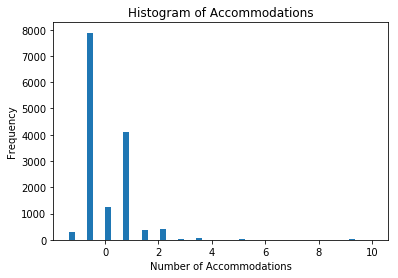

In [220]:
# visualize distribution of price (target variable)
plt.hist(data['accommodates'], bins=50)
plt.title("Histogram of Accommodations")
plt.xlabel("Number of Accommodations")
plt.ylabel("Frequency")
plt.show()

We see that a majority of listings have accomodations for 1-4 people. 1 bed typically accomodates 2 individuals, so let's plot beds instead to analyze how many of the listings are single bedroom listings.

In [59]:
print('Number of Unique Beds: ', np.unique(data['beds']))
for i in range(1, 17):
    print('Beds {}:'.format(i), len(data[data['beds'] == i]))

Number of Unique Beds:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16.]
Beds 1: 7107
Beds 2: 3768
Beds 3: 1184
Beds 4: 974
Beds 5: 261
Beds 6: 195
Beds 7: 34
Beds 8: 53
Beds 9: 6
Beds 10: 10
Beds 11: 1
Beds 12: 6
Beds 13: 1
Beds 14: 4
Beds 15: 0
Beds 16: 31


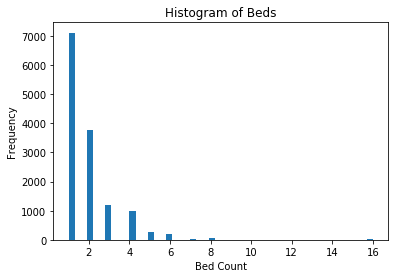

In [60]:
# visualize distribution of beds
plt.hist(data['beds'], bins=50)
plt.title("Histogram of Beds")
plt.xlabel("Bed Count")
plt.ylabel("Frequency")
plt.show()

We see that a majority of our listings are indeed single bedroom listings roughly 53%.

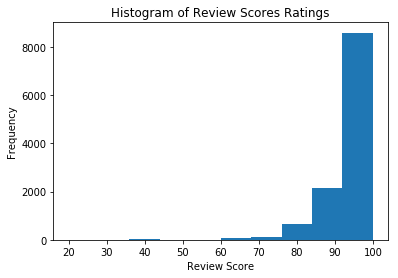

In [61]:
# visualize distribution of review scores ratings
plt.hist(data['review_scores_rating'][~data['review_scores_rating'].isnull()])
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

There are 2035 listings with no review_scores_rating (NaN) values. 
We will handle this by turning the `review_scores_ratings` into a categorical predictor. 
Based on the histogram, we see that a vast majority of the listings seem to have overall favorable ratings; 
i.e. skewed left distribution. We replace any NaN values that have no review with 'No Reviews' 
and we remove any remaining inconsistent NaN values that have a `number_of_reviews` > 0. 
We will also convert the `review_scores_ratings` into buckets. 
We will have the bucket ranges set more closely to a higher review score 
to accomodate for the skewed left distribution of the review scores.

In [68]:
# turn NaN scores with 0 reviews into 'No Reviews'
idx_vals = data['review_scores_rating'][data['number_of_reviews']==0].index.values.tolist()
data.loc[idx_vals, ('review_scores_rating')] = data['review_scores_rating'][data['number_of_reviews'] == 0].replace('NaN', 'No Reviews')

# remove inconsistent NaN values
data = data[~data['review_scores_rating'].isnull()]

In [69]:
# convert review_scores_rating into buckets
def convert_scores_buckets(val):
    if val == 'No Reviews':
        return 'No Reviews'
    elif val >= 95.0:
        return '95-100'
    elif val >= 90.0 and val < 95.0:
        return '90-94'
    elif val >= 85.0 and val < 90.0:
        return '85-89'
    elif val >= 80.0 and val < 85.0:
        return '80-84'
    elif val >= 70.0 and val < 80.0:
        return '70-79'
    elif val >= 60.0 and val < 70.0:
        return '60-69'
    elif val >= 50.0 and val < 60.0:
        return '50-59'
    elif val >= 40.0 and val < 50.0:
        return '40-49'
    elif val >= 30.0 and val < 40.0:
        return '30-39'
    elif val >= 20.0 and val < 30.0:
        return '20-29'
    elif val >= 10.0 and val < 20.0:
        return '10-19'
    elif val < 10.0:
        return '0-9'
    
data['review_scores_rating'] = data['review_scores_rating'].apply(convert_scores_buckets)


C:\Users\Palak08\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
print('Unique Values in the Column:', np.unique(data['review_scores_rating']))

Unique Values in the Column: ['20-29' '40-49' '50-59' '60-69' '70-79' '80-84' '85-89' '90-94' '95-100']


In [71]:
print('Number of remaining records:', len(data))

Number of remaining records: 11600


In [104]:
data['zipcode']=data.zipcode.str.replace('[^a-zA-Z]', '')

In [114]:
data['zipcode']=data.zipcode.str.lower()

In [142]:
columns=list(data.columns)

In [143]:
columns.remove('zipcode')

In [144]:
data.columns

Index(['id', 'host_id', 'zipcode', 'property_type', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'bed_type', 'price',
       'number_of_reviews', 'review_scores_rating',
       'calculated_host_listings_count', 'availability_30', 'minimum_nights',
       'bathrooms'],
      dtype='object')

In [145]:
data1 = data[columns]

In [146]:
data1.head(1)

,id,host_id,property_type,room_type,accommodates,bedrooms,beds,bed_type,price,number_of_reviews,review_scores_rating,calculated_host_listings_count,availability_30,minimum_nights,bathrooms
0,14831696,5476119,Apartment,Entire home/apt,6,2.0,6.0,Real Bed,145,4,95-100,1,14,3,1.0


In [149]:
# encode categorical variables
#zipcode_dummies = pd.get_dummies(data['zipcode'])
property_dummies = pd.get_dummies(data1['property_type'])
room_dummies = pd.get_dummies(data1['room_type'])
bed_dummies = pd.get_dummies(data1['bed_type'])
ratings_scores_dummies = pd.get_dummies(data1['review_scores_rating'])

# replace the old columns with our new one-hot encoded ones
df1 = pd.concat((data1.drop([
    'property_type', 'room_type', 'bed_type', 'review_scores_rating'], axis=1),property_dummies.astype(int), \
    room_dummies.astype(int), bed_dummies.astype(int), ratings_scores_dummies.astype(int)), \
    axis=1)

print('Number of Columns:', len(df1.columns))

# move target predictor 'price' to the end of the dataframe
cols = list(df1.columns.values)
idx = cols.index('price')
rearrange_cols = cols[:idx] + cols[idx+1:] + [cols[idx]]
df1 = df1[rearrange_cols]

Number of Columns: 48


In [150]:
# convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

non_cat_vars = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'calculated_host_listings_count', 'availability_30', 'minimum_nights', 'bathrooms']
for col in non_cat_vars:
    df1[col] = df1[col].astype(float)
    df1[col] = standardize_col(df1[col])
    
df1.head()

,id,host_id,accommodates,bedrooms,beds,number_of_reviews,calculated_host_listings_count,availability_30,minimum_nights,bathrooms,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,Guesthouse,Hostel,House,Hut,Loft,Other,Serviced apartment,Townhouse,Villa,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,20-29,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,price
0,14831696,5476119,2.157635,0.614730,2.799344,-0.458601,-0.208709,2.719536,0.018676,-0.351279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,145
1,3951251,3526186,-0.665268,-0.588183,-0.617939,-0.099648,-0.208709,-0.514877,-0.106621,-0.351279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,88
2,16590973,12749039,-0.665268,-0.588183,-0.617939,-0.458601,-0.208709,1.102329,-0.106621,-0.351279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,130
3,9283701,46755996,0.746183,0.614730,0.748974,-0.513825,-0.087452,-0.514877,0.143972,-0.351279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,110
4,6458721,15317293,-0.665268,-0.588183,-0.617939,-0.292930,-0.208709,0.178211,0.018676,-0.351279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,115


In [117]:
pd.options.display.max_columns=2000

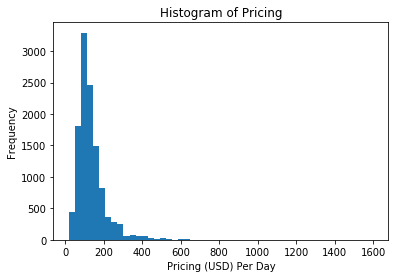

In [125]:
# visualize distribution of price (target variable)
plt.hist(df1['price'], bins=50)
plt.title("Histogram of Pricing")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()

We see the distribution for pricing is strongly skewed right. This again makes sense as a majority of the listings on Airbnb are single individual listings. Additionally, Airbnb does strongly cater to travelers who are looking for cheaper places to stay for short durations of time. There are of course listings with a high pricing as well; intuitively this matches with hosts that are listing a high value property such as an entire house. To compensate for the skewed right distribution, we will log the response variable and store the results in a new panda column. We will then run our baseline models on both the logged and original response and compare the results.

In [155]:
# log transform the response 'price'
df1['price_log'] = df1['price'].apply(lambda x: math.log(x))

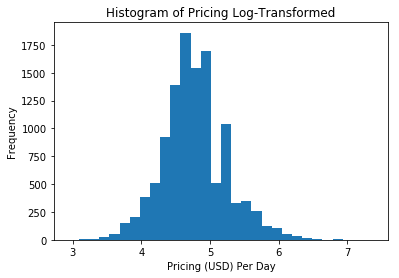

In [156]:
# visualize distribution of price (target variable)
plt.hist(df1['price_log'], bins=30)
plt.title("Histogram of Pricing Log-Transformed")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()

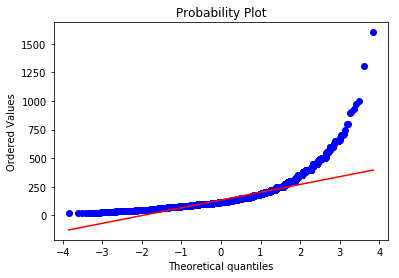

In [157]:
# qq plot for log-transformed pricing
stats.probplot(df1['price'], dist="norm", plot=pylab)
pylab.show()

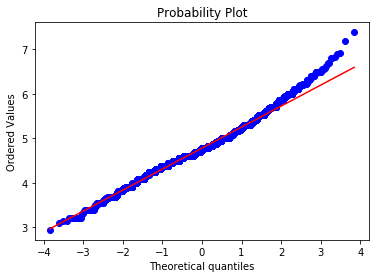

In [158]:
# qq plot for log-transformed pricing
stats.probplot(df1['price_log'], dist="norm", plot=pylab)
pylab.show()

We see that after transformation, the distribution for `price` resembles that of a normal distribution. We see from the Q-Q plots that log-transforming the response variable yields a distribution that more closely resembles that of a normal distribution. This normality validation is important in order to fit the assumptions of linear regression models.

In [159]:
# read to csv
df1.to_csv('listings_clean1.csv', index=False)

### EDA

C:\Users\Palak08\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


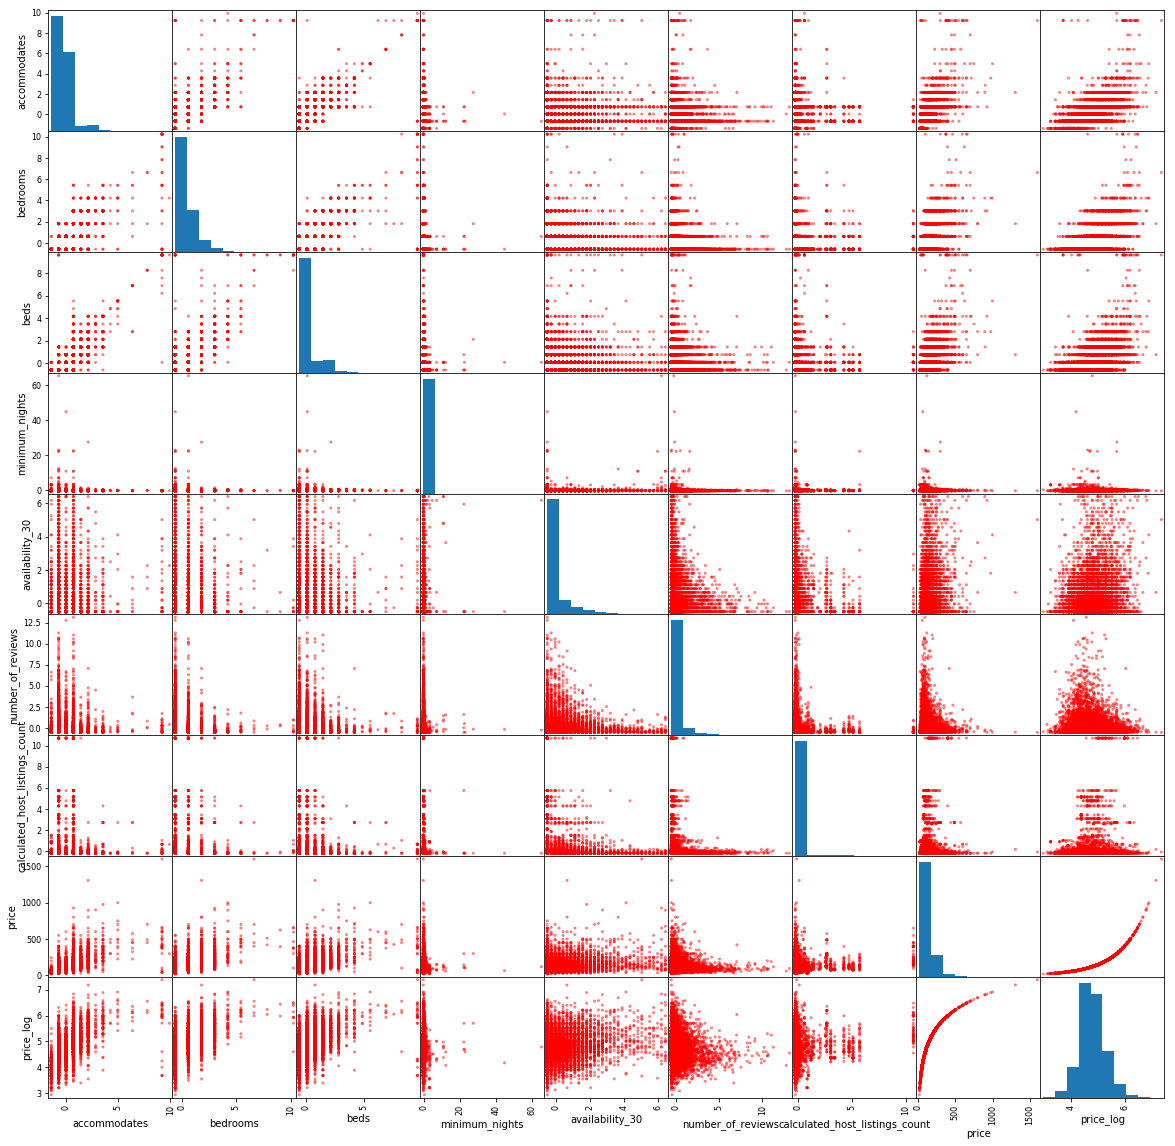

In [160]:
# check for collinearity and visualize relationship between each predictor and price
matrix_cols = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'availability_30' ,'number_of_reviews', 'calculated_host_listings_count', 'price', 'price_log']
axs = pd.scatter_matrix(df1[matrix_cols], figsize=(20, 20), c='red')

Based on the matrix output, there does not seem to be any obvious problems amongst the predictors. There does seem to be a relationship between the following predictors: `accommodates`, `bedrooms`, `beds` and `guests_included`. This makes intuitive sense as the more bedrooms a listing has the more individuals it can accommodate. However, we do see that the results are loosely related and not resemblance of a straight line which may be a result of varying accommodations, sleeping arrangements and layout of the listing itself. Thus, there is no strong evidence of collinearity among the predictors. We do note that the distributions for many of the predictors are strongly skewed right (including the standardization as well). Again, this makes intuitive sense as a majority of listings on Airbnb are single bed listings that typically seek to accommodate 1 or few persons.

### MODEL

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics


In [222]:
df1.columns

Index(['id', 'host_id', 'accommodates', 'bedrooms', 'beds',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_30', 'minimum_nights', 'bathrooms', 'Apartment',
       'Bed & Breakfast', 'Boat', 'Boutique hotel', 'Bungalow', 'Cabin',
       'Camper/RV', 'Chalet', 'Condominium', 'Dorm', 'Guesthouse', 'Hostel',
       'House', 'Hut', 'Loft', 'Other', 'Serviced apartment', 'Townhouse',
       'Villa', 'Yurt', 'Entire home/apt', 'Private room', 'Shared room',
       'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed', '20-29',
       '40-49', '50-59', '60-69', '70-79', '80-84', '85-89', '90-94', '95-100',
       'price', 'price_log'],
      dtype='object')

In [223]:
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X1=df1.select_dtypes(include=numerics).drop(['price_log','price'],axis=1).fillna(0)
y1=df1['price_log']

### XGBoost Regressor

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1,test_size=0.30)

C:\Users\Palak08\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:11:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.298496231131986
Validation MSE: 0.32357379374726875

Training r2: 0.5933
Validation r2: 0.5574


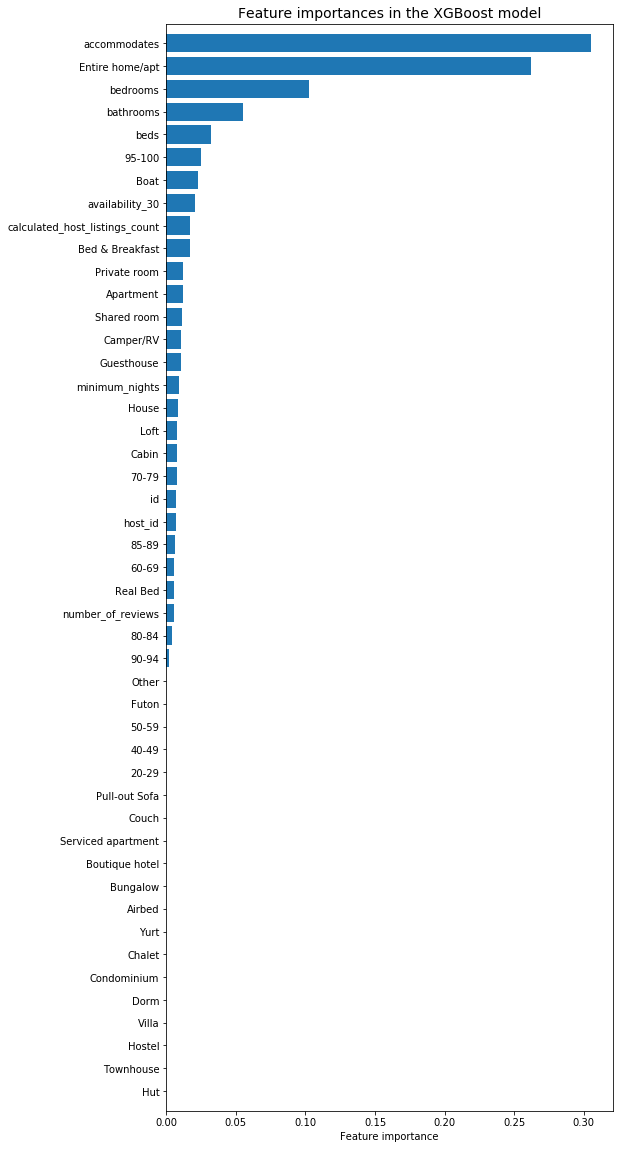

In [176]:

# Fitting the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results
#print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", np.sqrt(round(mean_squared_error(y_train, training_preds_xgb_reg),4)))
print("Validation MSE:", np.sqrt(round(mean_squared_error(y_test, val_preds_xgb_reg),4)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## Linear Regression

In [179]:
# Fitting the model
linear_reg = Lin_Reg()
linear_reg.fit(X_train, y_train)
training_preds_linear_reg = linear_reg.predict(X_train)
val_preds_linear_reg = linear_reg.predict(X_test)

In [187]:
# Printing the results
#print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", np.sqrt(round(mean_squared_error(y_train, training_preds_linear_reg),4)))
print("Validation MSE:", np.sqrt(round(mean_squared_error(y_test, val_preds_linear_reg),4)))
print("\nTraining r2:", round(r2_score(y_train, training_preds_linear_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_linear_reg),4))



Training MSE: 0.3260368077380221
Validation MSE: 0.33808283008753937

Training r2: 0.5145
Validation r2: 0.5169


### RandomForest Regressor

In [226]:
# random forest regressor
def random_forest_model(x_train, y_train, x_test, y_test):
    best_test_score = 0
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

def random_forest_tuned(best_depth, x, y, description, log_bool=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
    rf = RandomForestRegressor(n_estimators=50, max_depth=best_depth, oob_score=True)
    rf.fit(x_train, y_train)
    y_pred_test = rf.predict(x_test)
    if not log_bool:
        print('{}'.format(description), metrics.median_absolute_error(y_pred_test, y_test))
    if log_bool:
        print('{}'.format(description), metrics.median_absolute_error(np.exp(y_pred_test), np.exp(y_test)))

In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [231]:
x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [232]:
print('Train Score with Best Test:', rf_values[0])
print('Best Test Score:', rf_values[1])
print('Best Depth', rf_values[2])

Train Score with Best Test: 0.6598837595885945
Best Test Score: 0.5343352494570586
Best Depth 9


In [233]:
random_forest_tuned(rf_values[2], X1, y1, 'Median Absolute Error for Untransformed Response:')

Median Absolute Error for Untransformed Response: 0.1983874687567866


Tried three models : Linear Regression , a boosting model and an ensemble model like Randomforest. The best results were derived from  XGBoost. Randomforest, although gave less error but the diffrnce in train and test accuracy indicated overfitting.For tuning, score was taken at the maximum depth. Further, depending on the metric used, model can be tuned and best thresholds can be supplied as inputs for the hyper parameters.